In [41]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

from opt_utils import hyperplane_rounding, normalize_rows, eigen_proj, load_graph

In [42]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [43]:
# one iteration of elliptope optimization
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))

    manifold = pymanopt.manifolds.Elliptope(n, rank)
    @pymanopt.function.autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.optimizers.SteepestDescent(min_step_size=1e-3)
    solution = solver.run(problem, initial_point=initial_Y)

    return solution.point, solution.cost

In [52]:
# reduce rank by optimizing over a manifold
def closest_point(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 2:
        manifold = pymanopt.manifolds.Elliptope(n, target_rank)
        @pymanopt.function.autograd(manifold)
        def manifold_cost(Y):
            return np.trace(Y @ Y.T @ X)

        problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
        solver = pymanopt.optimizers.SteepestDescent(min_step_size=1e-3)
        Y_proj = solver.run(problem).point

    return Y_proj, target_rank

### Data

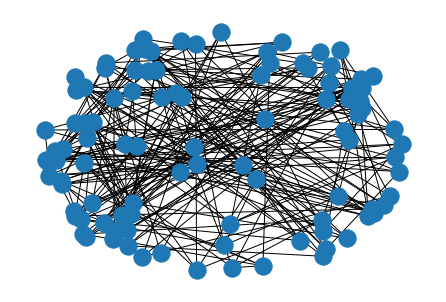

In [45]:
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

n = 100
G = load_graph(graph_file, n)

In [46]:
L = nx.laplacian_matrix(G).toarray() * 1.0

<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


## Solve SDP relaxation

In [47]:
X = cp.Variable((n,n), PSD=True)
constraints = [ X[i][i] == 1 for i in range(n) ]
prob = cp.Problem(cp.Maximize(1/4 * (cp.trace(L @ X))), constraints)
prob.solve()

87.3936690539831

In [48]:
opt_sdp_rank = np.linalg.matrix_rank(X.value, tol=1e-9)  # the optimal solution from the original BM method paper is 33

In [49]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 23
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -4.1283512124571171e+00    9.89289731e+00    
   2         -1.3898890482633012e+01    9.70029636e+00    
   3         -4.5459814363808178e+01    7.03294330e+00    
   4         -5.2266904495580356e+01    9.65540878e+00    
   5         -7.2483866193027438e+01    5.08249779e+00    
   6         -7.8830738193997860e+01    3.56332785e+00    
   7         -8.1800111527330529e+01    1.78970786e+00    
   8         -8.2851603175852063e+01    2.33261543e+00    
   9         -8.2882396426597992e+01    3.17850260e+00    
  10         -8.3003293632556165e+01    3.06124692e+00    
  11         -8.3449078957842374e+01    2.58676881e+00    
  12         -8.4527089321168177e+01    9.00035173e-01    
  13         -8.4864099055868877e+01    2.49625417e+00    
  14         -8.5784609515956731e+01    9.73339477e-01    
  15         -8.598835179

## Manifold iteration

### Eigenprojection + hyperplane rounding

In [50]:
eigen_proj_ranks = []
eigen_proj_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    eigen_proj_ranks += [rank_new]
    eigen_proj_costs += [-cost_val]
    Y_new, rank_new = eigen_proj(solution_new, True)
eigen_proj_cost, eigen_proj_solution = hyperplane_rounding(solution_new, cost)
eigen_proj_simple_rounding_cost = cost(Y_new)
eigen_proj_ranks += [1, 1]
eigen_proj_costs += [-eigen_proj_cost, -eigen_proj_simple_rounding_cost]

Current rank: 23
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -6.3098932853782861e+00    1.03407060e+01    
   2         -1.6507549019176530e+01    1.01021667e+01    
   3         -4.9173411609579375e+01    7.07903063e+00    
   4         -5.0469940541473697e+01    1.02172595e+01    
   5         -5.5476019843760234e+01    9.51495574e+00    
   6         -7.1533196467461707e+01    5.92343007e+00    
   7         -7.6073514827771874e+01    5.52584488e+00    
   8         -8.1177821104939966e+01    3.29363054e+00    
   9         -8.3083325793240547e+01    1.76316571e+00    
  10         -8.3702096800122987e+01    1.75094662e+00    
  11         -8.4302430793225298e+01    1.04625106e+00    
  12         -8.4623575115693626e+01    1.91252601e+00    
  13         -8.5191209064652170e+01    8.25022550e-01    
  14         -8.5409839367750848e+01    1.21014651e+00    
  15         -8.552532580

### Closest point + hyperplane rounding

In [53]:
closest_point_ranks = []
closest_point_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    closest_point_ranks += [rank_new]
    closest_point_costs += [-cost_val]
    Y_new, rank_new = closest_point(solution_new)
closest_point_cost, closest_point_solution = hyperplane_rounding(solution_new, cost)
closest_point_ranks += [1]
closest_point_costs += [-closest_point_cost]

Current rank: 23
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -6.6801154698215486e+00    1.03970973e+01    
   2         -1.6944126900972361e+01    1.01788286e+01    
   3         -4.9967766046465805e+01    7.19904487e+00    
   4         -5.0766914872061221e+01    1.02381275e+01    
   5         -5.3897954715602374e+01    9.82068933e+00    
   6         -6.5101208074604784e+01    7.79904217e+00    
   7         -7.7507184476308353e+01    4.83875367e+00    
   8         -8.1556914851696575e+01    2.77563874e+00    
   9         -8.2934831144629058e+01    2.09364994e+00    
  10         -8.3617589922371010e+01    2.24339213e+00    
  11         -8.4247105570152087e+01    2.04293071e+00    
  12         -8.4534789350975132e+01    2.29578188e+00    
  13         -8.5275241396293026e+01    8.72659219e-01    
  14         -8.5634653462527183e+01    1.25904975e+00    
  15         -8.589173485

## Benchmark: hyperplane rounding of SDP solution

In [ ]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

## Plots

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(eigen_proj_ranks, eigen_proj_costs, label="eigen projection", marker="o")
plt.plot(closest_point_ranks, closest_point_costs, label="closest point", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()